In [6]:
a <- read.table("outcomes_qc_05_21.csv",sep=",",header=T)

In [9]:
table(a$pbmty)


              14               15               88               99 
               5                4               35               24 
 ALLO (post rel)    ALLO (pre CR)       ALLOGENEIC    AUTO (2nd CR) 
              31               63               62               99 
AUTO (post rel2)    AUTO (pre CR)   AUTO (relapse)       AUTOLOGOUS 
              85               10                4                1 
      MISMATCHED              MUD             NONE            OTHER 
              20              169             1730               19 
               S        SYNGENEIC          UNKNOWN 
               2                1               67 

In [4]:
msebmt <- msprep(data = ebmt, trans = tmat, time = c(NA, "rec", "ae",
"recae", "rel", "srv"), status = c(NA, "rec.s", "ae.s", "recae.s",
"rel.s", "srv.s"), keep = c("match", "proph", "year", "agecl"))
msebmt[msebmt$id == 1, c(1:8, 10:12)]

id,from,to,trans,Tstart,Tstop,time,status,proph,year,agecl
1,1,2,1,0,22,22,1,no,1995-1998,20-40
1,1,3,2,0,22,22,0,no,1995-1998,20-40
1,1,5,3,0,22,22,0,no,1995-1998,20-40
1,1,6,4,0,22,22,0,no,1995-1998,20-40
1,2,4,5,22,995,973,0,no,1995-1998,20-40
1,2,5,6,22,995,973,0,no,1995-1998,20-40
1,2,6,7,22,995,973,0,no,1995-1998,20-40


In [6]:
events(msebmt)

$Frequencies
        to
from       Tx  Rec   AE Rec+AE  Rel Death no event total entering
  Tx        0  785  907      0   95   160      332           2279
  Rec       0    0    0    227  112    39      407            785
  AE        0    0    0    433   56   197      221            907
  Rec+AE    0    0    0      0  107   137      416            660
  Rel       0    0    0      0    0     0      370            370
  Death     0    0    0      0    0     0      533            533

$Proportions
        to
from             Tx        Rec         AE     Rec+AE        Rel      Death
  Tx     0.00000000 0.34444932 0.39798157 0.00000000 0.04168495 0.07020623
  Rec    0.00000000 0.00000000 0.00000000 0.28917197 0.14267516 0.04968153
  AE     0.00000000 0.00000000 0.00000000 0.47739802 0.06174201 0.21719956
  Rec+AE 0.00000000 0.00000000 0.00000000 0.00000000 0.16212121 0.20757576
  Rel    0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
  Death  0.00000000 0.00000000 0.000000

In [7]:
covs <- c("match", "proph", "year", "agecl")
msebmt <- expand.covs(msebmt, covs, longnames = FALSE)
msebmt[msebmt$id == 1, -c(9, 10, 12:48, 61:84)]

id,from,to,trans,Tstart,Tstop,time,status,year,year2.1,⋯,year2.3,year2.4,year2.5,year2.6,year2.7,year2.8,year2.9,year2.10,year2.11,year2.12
1,1,2,1,0,22,22,1,1995-1998,1,⋯,0,0,0,0,0,0,0,0,0,0
1,1,3,2,0,22,22,0,1995-1998,0,⋯,0,0,0,0,0,0,0,0,0,0
1,1,5,3,0,22,22,0,1995-1998,0,⋯,1,0,0,0,0,0,0,0,0,0
1,1,6,4,0,22,22,0,1995-1998,0,⋯,0,1,0,0,0,0,0,0,0,0
1,2,4,5,22,995,973,0,1995-1998,0,⋯,0,0,1,0,0,0,0,0,0,0
1,2,5,6,22,995,973,0,1995-1998,0,⋯,0,0,0,1,0,0,0,0,0,0
1,2,6,7,22,995,973,0,1995-1998,0,⋯,0,0,0,0,1,0,0,0,0,0


In [8]:
msebmt[, c("Tstart", "Tstop", "time")] <- msebmt[, c("Tstart",
"Tstop", "time")]/365.25

In [250]:
res1 <- cv.glmnet(as.matrix(msebmt["trans"]), Surv(msebmt$Tstop-msebmt$Tstart, msebmt$status), family="cox",alpha=1,nfolds=10)

ERROR: Error in glmnet(x, y, weights = weights, offset = offset, lambda = lambda, : x should be a matrix with 2 or more columns


In [9]:
c0 <- coxph(Surv(Tstart, Tstop, status) ~ strata(trans), data = msebmt,
method = "breslow")

In [15]:
coxph(Surv(Tstart, Tstop, status) ~ strata(trans), data = msebmt[,c("id","trans","Tstart","Tstop","status")],method = "breslow")

Call:  coxph(formula = Surv(Tstart, Tstop, status) ~ strata(trans), 
    data = msebmt[, c("id", "trans", "Tstart", "Tstop", "status")], 
    method = "breslow")

Null model
  log likelihood= -21684.27 
  n= 15512 

In [264]:
msf0 <- msfit(object = c0, vartype = "greenwood", trans = tmat)

In [185]:
table(msebmt[msebmt$from==4,]$to)


  5   6 
660 660 

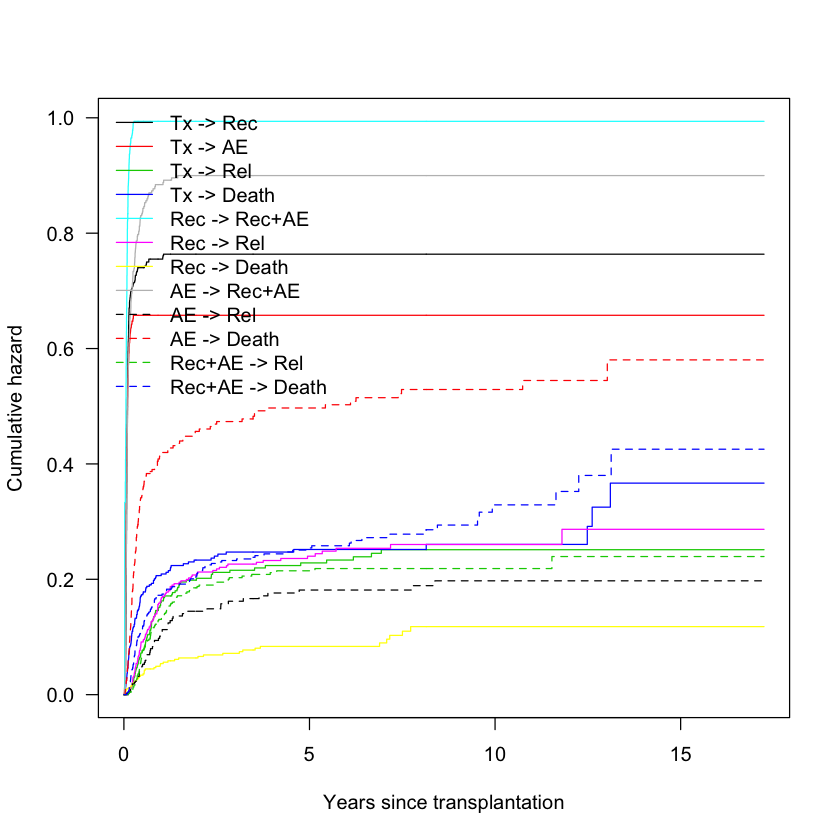

In [217]:
plot(msf0, las = 1, lty = rep(1:2, c(8, 4)),xlab = "Years since transplantation")

In [240]:
head(msf0$Haz[msf0$Haz$trans==1,])
head(msf0$Haz[msf0$Haz$trans==2,])
head(msf0$Haz[msf0$Haz$trans==3,])
head(msf0$Haz[msf0$Haz$trans==4,])


time,Haz,trans
0.002737851,0.000000000,1
0.008213552,0.000000000,1
0.010951403,0.000000000,1
0.013689254,0.000000000,1
0.016427105,0.000443066,1
0.019164956,0.001333142,1


,time,Haz,trans
518,0.002737851,0.0004389816,2
519,0.008213552,0.0021956790,2
520,0.010951403,0.0039554678,2
521,0.013689254,0.0079237218,2
522,0.016427105,0.0119113159,2
523,0.019164956,0.0190319212,2


,time,Haz,trans
1035,0.002737851,0,3
1036,0.008213552,0,3
1037,0.010951403,0,3
1038,0.013689254,0,3
1039,0.016427105,0,3
1040,0.019164956,0,3


,time,Haz,trans
1552,0.002737851,0.0000000000,4
1553,0.008213552,0.0000000000,4
1554,0.010951403,0.0004399472,4
1555,0.013689254,0.0013217814,4
1556,0.016427105,0.0013217814,4
1557,0.019164956,0.0026568949,4


In [236]:
1-0.0013217814-0.0119113159

[1] 0.9867669

In [218]:
pt0 <- probtrans(msf0, predt = 0, method = "greenwood")

Warning message in plot.window(...):
“"method" is not a graphical parameter”Warning message in plot.xy(xy, type, ...):
“"method" is not a graphical parameter”Warning message in axis(side = side, at = at, labels = labels, ...):
“"method" is not a graphical parameter”Warning message in axis(side = side, at = at, labels = labels, ...):
“"method" is not a graphical parameter”Warning message in box(...):
“"method" is not a graphical parameter”Warning message in title(...):
“"method" is not a graphical parameter”Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“"method" is not a graphical parameter”Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“"method" is not a graphical parameter”Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“"method" is not a graphical parameter”Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“"method" is not a graphical parameter”Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“"method" is not 

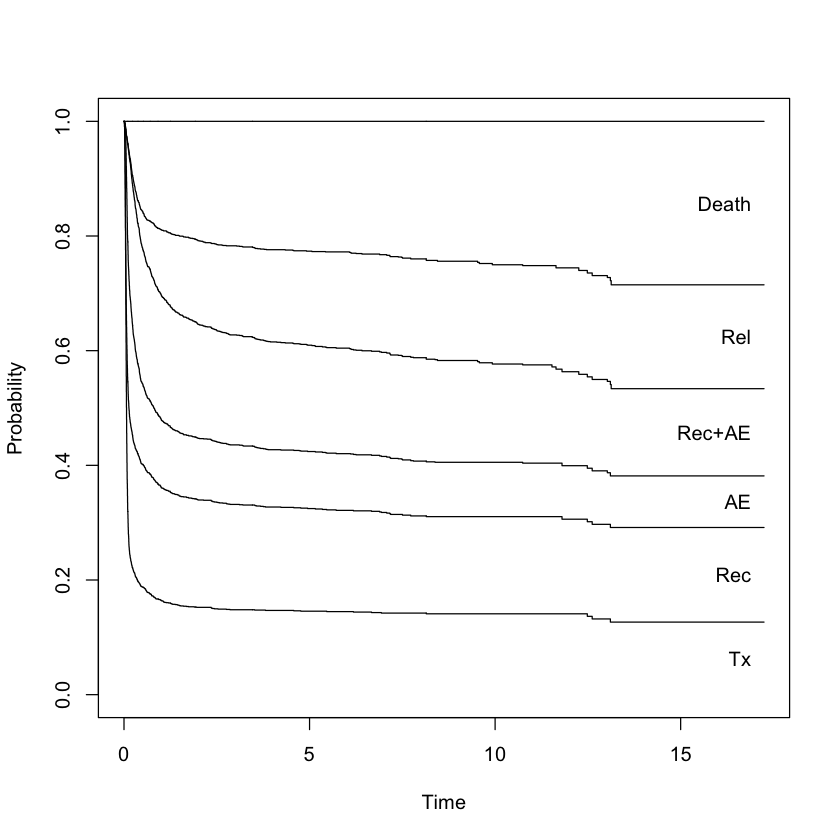

In [251]:
plot(pt0,method="filled")

In [257]:
cfull <- coxph(Surv(Tstart, Tstop, status) ~ match.1 +
match.2 + match.3 + match.4 + match.5 + match.6 +
match.7 + match.8 + match.9 + match.10 + match.11 +
match.12 + proph.1 + proph.2 + proph.3 + proph.4 +
proph.5 + proph.6 + proph.7 + proph.8 + proph.9 +
proph.10 + proph.11 + proph.12 + year1.1 + year1.2 +
year1.3 + year1.4 + year1.5 + year1.6 + year1.7 +
year1.8 + year1.9 + year1.10 + year1.11 + year1.12 +
year2.1 + year2.2 + year2.3 + year2.4 + year2.5 +
year2.6 + year2.7 + year2.8 + year2.9 + year2.10 +
year2.11 + year2.12 + agecl1.1 + agecl1.2 + agecl1.3 +
agecl1.4 + agecl1.5 + agecl1.6 + agecl1.7 + agecl1.8 +
agecl1.9 + agecl1.10 + agecl1.11 + agecl1.12 + agecl2.1 +
agecl2.2 + agecl2.3 + agecl2.4 + agecl2.5 + agecl2.6 +
agecl2.7 + agecl2.8 + agecl2.9 + agecl2.10 + agecl2.11 +
agecl2.12 + strata(trans), data = msebmt, method = "breslow")

In [269]:
whA <- which(msebmt$proph == "yes" & msebmt$match == "no gender mismatch"& msebmt$year == "1995-1998" & msebmt$agecl == "<=20")
patA <- msebmt[rep(whA[1], 12), 9:12]
patA$trans <- 1:12
attr(patA, "trans") <- tmat
patA <- expand.covs(patA, covs, longnames = FALSE)
patA$strata <- patA$trans
msfA <- msfit(object=cfull,patA, trans = tmat)

In [303]:
summary(cfull)

Call:
coxph(formula = Surv(Tstart, Tstop, status) ~ match.1 + match.2 + 
    match.3 + match.4 + match.5 + match.6 + match.7 + match.8 + 
    match.9 + match.10 + match.11 + match.12 + proph.1 + proph.2 + 
    proph.3 + proph.4 + proph.5 + proph.6 + proph.7 + proph.8 + 
    proph.9 + proph.10 + proph.11 + proph.12 + year1.1 + year1.2 + 
    year1.3 + year1.4 + year1.5 + year1.6 + year1.7 + year1.8 + 
    year1.9 + year1.10 + year1.11 + year1.12 + year2.1 + year2.2 + 
    year2.3 + year2.4 + year2.5 + year2.6 + year2.7 + year2.8 + 
    year2.9 + year2.10 + year2.11 + year2.12 + agecl1.1 + agecl1.2 + 
    agecl1.3 + agecl1.4 + agecl1.5 + agecl1.6 + agecl1.7 + agecl1.8 + 
    agecl1.9 + agecl1.10 + agecl1.11 + agecl1.12 + agecl2.1 + 
    agecl2.2 + agecl2.3 + agecl2.4 + agecl2.5 + agecl2.6 + agecl2.7 + 
    agecl2.8 + agecl2.9 + agecl2.10 + agecl2.11 + agecl2.12 + 
    strata(trans), data = msebmt, method = "breslow")

  n= 15512, number of events= 3255 

               coef exp(coef)  se

In [397]:
(0.6937*1.4935)*0.0003765615
0.757598*0.892342*0.0141924824
0.945169*0.621522*0.0010514348 


[1] 0.0003899463

[1] 0.009594636

[1] 0.0006176584

NULL

In [ ]:
ptA

In [393]:
summary(msfA)

An object of class 'msfit'

Transition 1 (head and tail):

         time          Haz trans
1 0.002737851 0.0000000000     1
2 0.008213552 0.0000000000     1
3 0.010951403 0.0000000000     1
4 0.013689254 0.0000000000     1
5 0.016427105 0.0003765615     1
6 0.019164956 0.0011328385     1

...

        time       Haz trans
512 12.48460 0.6774274     1
513 12.61602 0.6774274     1
514 13.02396 0.6774274     1
515 13.10609 0.6774274     1
516 13.12799 0.6774274     1
517 17.24572 0.6774274     1

Transition 2 (head and tail):

           time          Haz trans
518 0.002737851 0.0003061179     2
519 0.008213552 0.0015310860     2
520 0.010951403 0.0027583438     2
521 0.013689254 0.0055253716     2
522 0.016427105 0.0083061336     2
523 0.019164956 0.0132711189     2

...

         time      Haz trans
1029 12.48460 0.464366     2
1030 12.61602 0.464366     2
1031 13.02396 0.464366     2
1032 13.10609 0.464366     2
1033 13.12799 0.464366     2
1034 17.24572 0.464366     2

Transition 3 (

In [272]:
ptA <- probtrans(msfA, predt = 0)

In [ ]:
ptA